## Логистическая регрессия

In [6]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator
from sklearn.metrics import log_loss
from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,6)

Реализуйте обучение логистической регрессии с $L^1$ и $L^2$ регуляризацией с помощью метода Stochastic Gradient Descent (SGD)

#### Замечания
* В SGD градиент расчитывается по одному случайному объекту
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в выборке (тем или иным способом)

**Задача классификации**

$X$ – обучающая выборка размеров $\ell \times (d+1)$ (первый столбец – вектор из единиц);

$y$ – вектор ответов, $y_i \in \{-1, 1\}$.

Логистическая регрессия с $L_1$-регуляризацией сводится к задаче минимизации:
$$ C\sum_{i=0}^\ell \log{(1 + e^{-y_iw^Tx_i})} + \sum_{j=1}^d |w_j| \rightarrow min_w$$

Логистическая регрессия с $L_2$-регуляризацией сводится к задаче минимизации:
$$ C\sum_{i=0}^\ell \log{(1 + e^{-y_iw^Tx_i})} + \frac{1}{2}\sum_{j=1}^d w_j^2 \rightarrow min_w$$

Веса логистической регрессии при обучении стохастическим градиентным спуском будут пересчитываться по формуле: 

$L_1$-регуляризация: $w_j^{(t+1)} = w_j^{(t)} + \eta (Cy_i x_{ij} \sigma(-y_iw^Tx_i) -  \delta_{j\neq0}sgn(w_j)$

$L_2$-регуляризация: $w_j^{(t+1)} = w_j^{(t)} + \eta (Cy_i x_{ij} \sigma(-y_iw^Tx_i) -  \delta_{j\neq0}w_j)$
 
Здесь 
- $i \in {0,\ldots, \ell-1}, j \in {0,\ldots, d}$
- C – коэффициент регуляризации
- $x_{ij} $ – элемент матрицы X в строке $i$ и столбце $j$ (нумерация с 0), 
- $w_j^{(t)}$ – значение $j$-ого элемента вектора весов $w$ на шаге $t$ стохастического градиентного спуска
- $\eta$ – шаг градиентного спуска
- $\delta_{j\neq0}$ – символ Кронекера, то есть 1, когда $j\neq0$ и $0$ – в противном случае

# Реализация модели

In [2]:
class BasicRegression(BaseEstimator):
    
    def __init__(self, learning_rate=0.001, penalty='l2', C=1.0, max_epoch=10):
        """
        C - коэф. регуляризации
        learning_rate - скорость спуска
        max_epoch - максимальное количество эпох
        """
        self.C = C
        self.penalty = penalty
        self.learning_rate = learning_rate
        self.max_epoch = max_epoch
        
        self.errors_ = []
        self.weights_ = []
        self.best_weights_ = None
        
        self.X = None
        self.y = None
        self.n_samples = None
        self.n_features = None
        
    def _add_intersept(self, X):
        x0 = np.ones([X.shape[0], 1])
        return np.hstack((x0, X))

In [3]:
class SGDClassifier(BasicRegression):
    
    @staticmethod
    def sigmoid(z):
        z = z.flatten()
        z[z > 100] = 100
        z[z < -100] = -100
        return 1. / (1 + np.exp(-z))
    
    # Производная функционала потерь
    def _der_loss(self, w, index):
        xi = self.X[index, :]
        yi = self.y[index]
        
        der_loss = self.C*yi*xi*self.sigmoid(-yi*np.dot(w, xi))
        return der_loss

    # Производная регуляризатора
    def _der_reg(self, w):
        der_reg = np.zeros(self.n_features)
        
        kronecker = np.ones(self.n_features)
        kronecker[0] = 0
        
        if self.penalty == 'l1':
            der_reg = np.sign(w)*kronecker
        elif self.penalty == 'l2':
            der_reg = w*kronecker
            
        return der_reg
    
    def _stochastic_gradient_step(self, w, index):
        gradient = self._der_loss(w, index) - self._der_reg(w)
        w_new = w + self.learning_rate * gradient
        
        return w_new
    
    def _sgd(self, w_prev):
        # i - номер объекта, полный проход по всей выборке
        for i in np.random.permutation(self.n_samples):
            w_new = self._stochastic_gradient_step(w_prev, i)
            probs = self.sigmoid(np.dot(self.X, w_new))
            error = log_loss(self.y, probs)

            self.errors_.append(error)
            self.weights_.append(w_new)
            w_prev = w_new
            
        return w_new
    
    def _setup_data(self, X, y):
        self.X = X
        self.y = y
        self.n_samples = X.shape[0]
        self.n_features = X.shape[1] + 1
        
    def _update_weights(self):
        weights_ = np.array(self.weights_)
        errors_ = np.array(self.errors_)
       
         # минимальная ошибка и вектор весов, при котором ошибка минимальна
        index = np.argmin(errors_)
        self.min_error_ = errors_[index]
        self.best_weights_ = weights_[index]

    def fit(self, X, y=None):
        self._setup_data(X, y)
        
        # добавляем к матрице X слева столбец из единиц
        self.X = self._add_intersept(self.X)
        
        # Инициализируем вектор весов w нулями
        w_prev = np.zeros(self.n_features)
        
        # Проход по эпохам
        for _ in np.arange(self.max_epoch):
            w_prev = self._sgd(w_prev)

        self._update_weights()
        return self
    
    def partial_fit(self, X, y=None):
        self._setup_data(X, y)
        self.X = self._add_intersept(self.X)
        w_prev = self.weights_[-1]
        
        for _ in np.arange(self.max_epoch):
            w_prev = self._sgd(w_prev)
        
        self._update_weights()
        return self
    
    def predict(self, X):
        X = self._add_intersept(X)
        probs = self.sigmoid(np.dot(X, self.best_weights_))
        return np.array([-1 if prob < 0.5 else 1 for prob in probs])
    
    def predict_proba(self, X):
        X = self._add_intersept(X)
        probs0 = self.sigmoid(np.dot(X, self.best_weights_))
        probs1 = np.array([1-prob for prob in probs0])
        return np.column_stack((probs0, probs1))

In [4]:
def plot_results(X, y, model):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.05))
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    
    Z = Z.reshape(xx.shape)
    axes[0].contourf(xx, yy, Z, cmap=ListedColormap(['red', 'blue']), alpha=0.2)
    axes[0].scatter(X[:,0], X[:,1], c=y)
    
    axes[1].plot(np.arange(len(model.errors_)), model.errors_)
    axes[1].set_xlabel('Iteration')
    axes[1].set_ylabel('log_loss');

## Проверка на синтетических данных (2 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

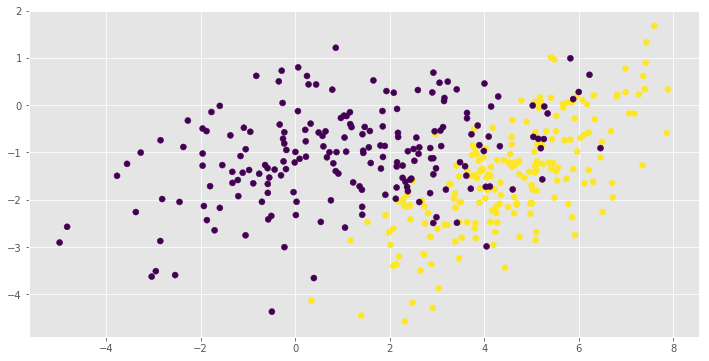

In [7]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.ones(200)*(-1)]

plt.scatter(X[:,0], X[:,1], c=y);

In [8]:
%%time
model = SGDClassifier(C=50, learning_rate=0.0001, max_epoch=10, penalty='l2')
model.fit(X, y)

CPU times: user 3.16 s, sys: 3.5 ms, total: 3.16 s
Wall time: 3.16 s


In [9]:
print('log loss:', model.min_error_)
print('weights:', model.best_weights_)

log loss: 0.4030622062006606
weights: [-1.74993204  0.5607567  -0.32226238]


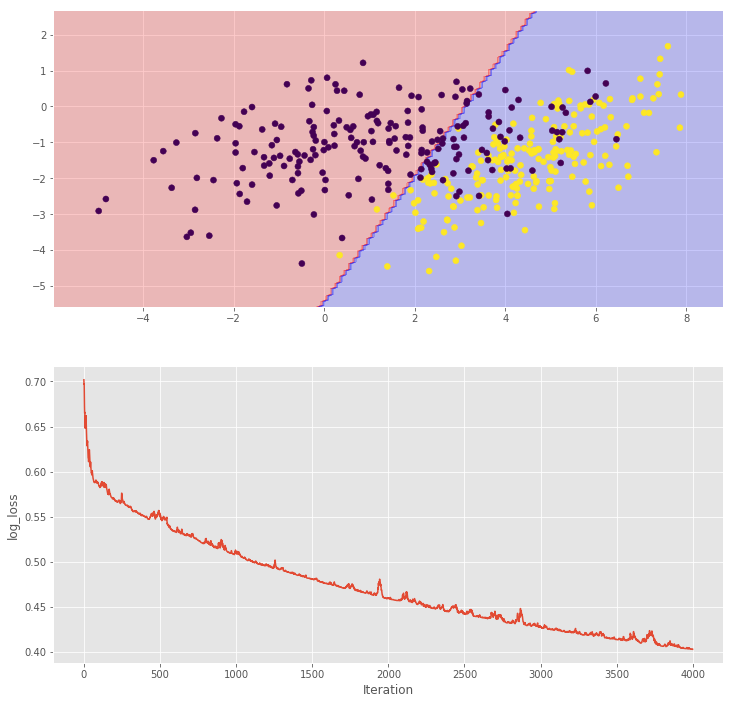

In [10]:
plot_results(X, y, model)

Дообучим немного модель: 

In [11]:
%%time
model.partial_fit(X, y)

CPU times: user 3.16 s, sys: 9.95 ms, total: 3.17 s
Wall time: 3.17 s


SGDClassifier(C=50, learning_rate=0.0001, max_epoch=10, penalty='l2')

In [12]:
print('log loss:', model.min_error_)
print('weights:', model.best_weights_)

log loss: 0.3524481189646425
weights: [-2.66703585  0.68916941 -0.57348558]


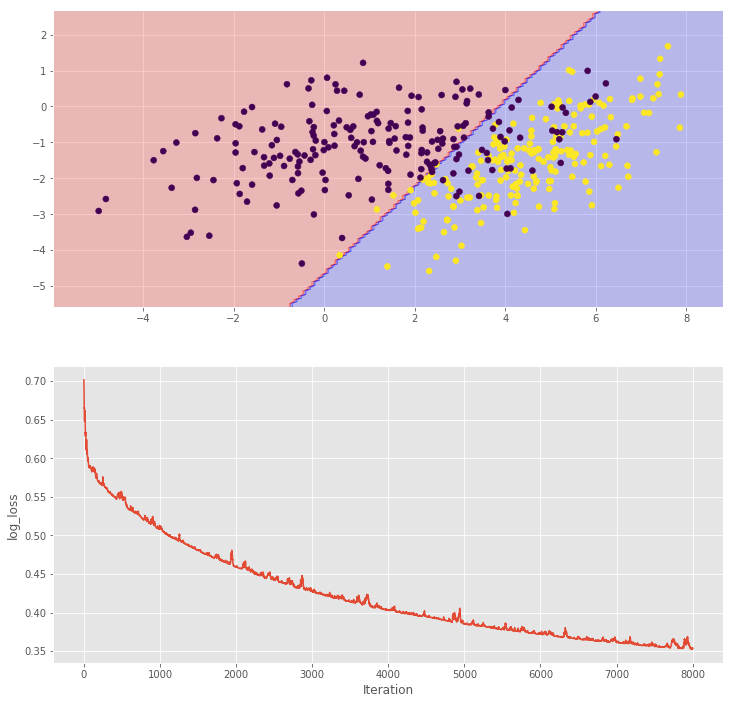

In [13]:
plot_results(X, y, model)

## Анализ сходимости

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/эпохи (выбрать одно) для разных `alpha`.

#### L2-регуляризация

In [14]:
%%time
model1 = SGDClassifier(C=50, learning_rate=0.1, max_epoch=100, penalty='l2')
model2 = SGDClassifier(C=50, learning_rate=0.01, max_epoch=100, penalty='l2')
model3 = SGDClassifier(C=50, learning_rate=0.001, max_epoch=100, penalty='l2')
model4 = SGDClassifier(C=50, learning_rate=0.0001, max_epoch=100, penalty='l2')

model1.fit(X, y)
model2.fit(X, y)
model3.fit(X, y)
model4.fit(X, y)

CPU times: user 2min 23s, sys: 480 ms, total: 2min 24s
Wall time: 2min 24s


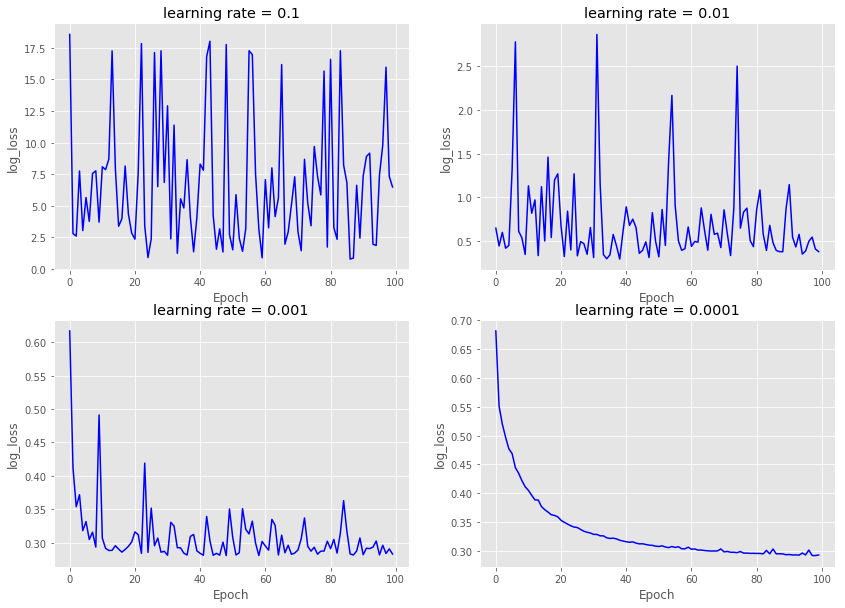

In [15]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
n_samples = X.shape[0]
for model, label, ax in zip([model1, model2, model3, model4], \
                        ['0.1', '0.01', '0.001', '0.0001'], axes.ravel()):
    
    errors = model.errors_[::n_samples]
    ax.plot(np.arange(len(errors)), errors, label=label, c='blue')
    ax.set_title('learning rate = '+label)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('log_loss');

#### L1-регуляризация

In [16]:
%%time
model1 = SGDClassifier(C=50, learning_rate=0.1, max_epoch=100, penalty='l1')
model2 = SGDClassifier(C=50, learning_rate=0.01, max_epoch=100, penalty='l1')
model3 = SGDClassifier(C=50, learning_rate=0.001, max_epoch=100, penalty='l1')
model4 = SGDClassifier(C=50, learning_rate=0.0001, max_epoch=100, penalty='l1')

model1.fit(X, y)
model2.fit(X, y)
model3.fit(X, y)
model4.fit(X, y)

CPU times: user 2min 13s, sys: 344 ms, total: 2min 14s
Wall time: 2min 14s


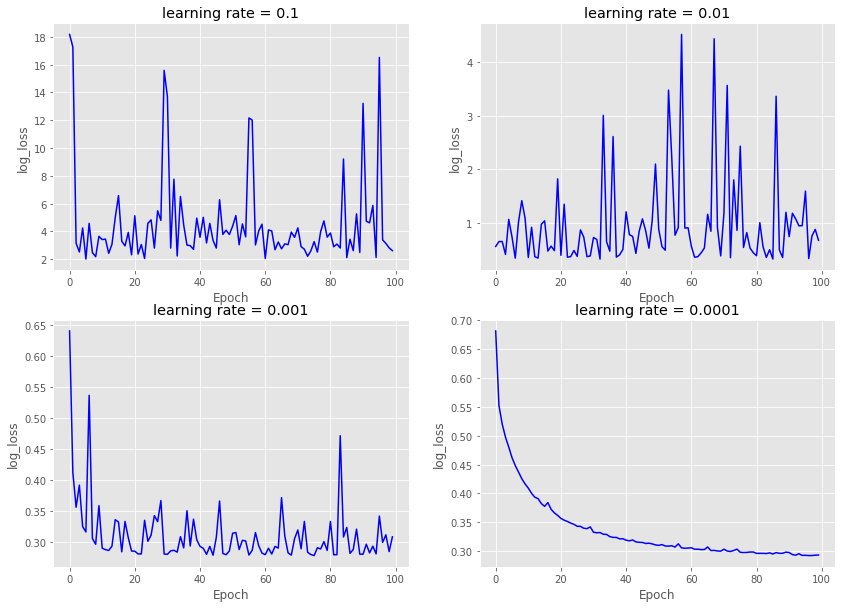

In [17]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))
n_samples = X.shape[0]
for model, label, ax in zip([model1, model2, model3, model4], \
                        ['0.1', '0.01', '0.001', '0.0001'], axes.ravel()):
    
    errors = model.errors_[::n_samples]
    ax.plot(np.arange(len(errors)), errors, label=label, c='blue')
    ax.set_title('learning rate = '+label)
    ax.set_xlabel('Epoch')
    ax.set_ylabel('log_loss');